# MNIST

고등학생과 미국 조사국 직원들이 손으로 쓴 7만개의 작은 숫자 이미지를 모은 데이터 

In [1]:
import numpy as np
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [81]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [2]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
x,y=mnist['data'],mnist['target']
x.shape

(70000, 784)

In [4]:
y.shape

(70000,)

각 특성은 0(흰색)-255(검정)까지의 픽셀 강도를 나타냄

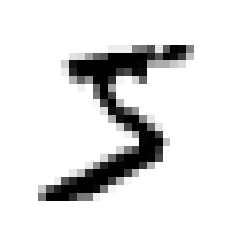

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit=x[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

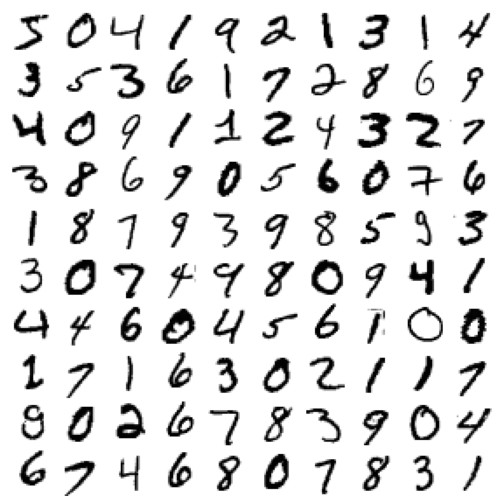

In [6]:
plt.figure(figsize=(9,9))
example_images = x[:100]
plot_digits(example_images, images_per_row=10)

In [7]:
y=y.astype('int64')

In [8]:
y[0]

5

In [9]:
x_train,x_test,y_train,y_test=x[:60000],x[60000:],y[:60000],y[60000:]

# 이진 분류기 훈련

숫자 5만 식별

In [10]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

확률적경사하강법(SGD) 분류기

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

- 교차 검증

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [15]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,x_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

정확도를 분류기의 성능 측정 지표로 사용하지 않는 이유

- 오차 행렬

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

N:5 아님, P:5  

TN:53892,TP:3530,FP:687,FN:1891

- precision(정밀도)  
$$\frac{TP}{TP+FP}$$  
- recall (재현율)   
$$\frac{TP}{TP+FN}$$  

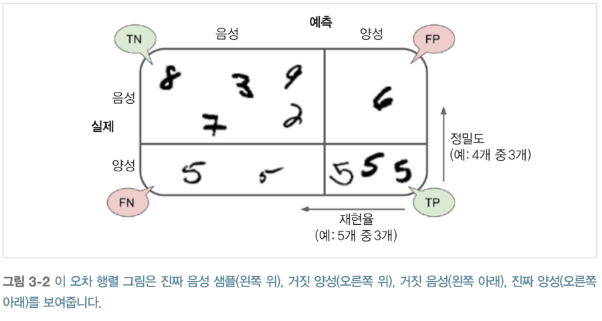

- 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

- f1 score

$$\frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}}=2\times\frac{정밀도\times재현율}{정밀도+재현율}=\frac{TP}{TP+\frac{FN+FP}{2}}$$

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

- 트레이드오프

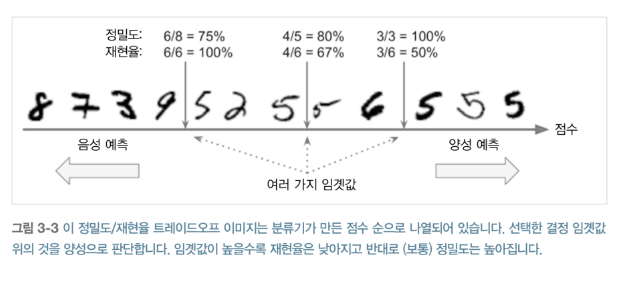

In [21]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores=cross_val_predict(sgd_clf,x_train,y_train_5,cv=3,method='decision_function')

In [25]:
from sklearn.metrics import precision_recall_curve
precision,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

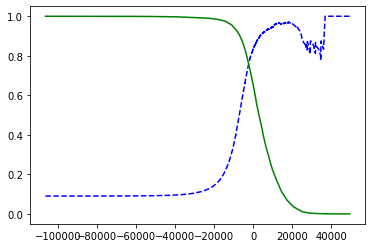

In [26]:
def plot_p_r_t(precision,recalls,thresholds):
    plt.plot(thresholds,precision[:-1],'b--',label='정밀도')
    plt.plot(thresholds,recalls[:-1],'g-',label='재현율')
    [...]

plot_p_r_t(precision,recalls,thresholds)
plt.show()

In [27]:
threshold_90=thresholds[np.argmax(precision>=0.9)]
y_train_90=(y_scores>=threshold_90)

In [28]:
precision_score(y_train_5,y_train_90)

0.9000345901072293

In [29]:
recall_score(y_train_5,y_train_90)

0.4799852425751706

- roc커브

FPR에 대한 TPR의 곡선  

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5,y_scores)

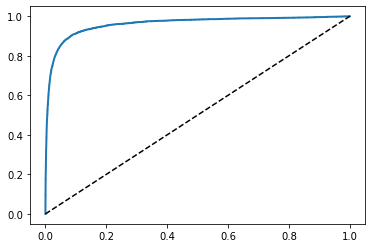

In [31]:
def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    [...]

plot_roc(fpr,tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

`RandomForestClassifier`는 decision_function()이 없고 predict_proba()가 있음

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_proba_pred=cross_val_predict(forest_clf,x_train,y_train_5,cv=3,method='predict_proba')

In [34]:
y_scores_forest=y_proba_pred[:,1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5,y_scores_forest)

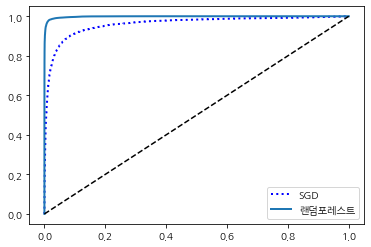

In [35]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.plot(fpr, tpr,'b:' ,linewidth=2,label='SGD')
plot_roc(fpr_forest,tpr_forest,'랜덤포레스트')
plt.legend(loc='lower right')
plt.show()

In [36]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

# 다중 분류

SGD분류기,랜덤포레스트,나이브 베이즈 같은 거는 여러 클래스를 직접 처리, 로직스틱이나 SVM은 이진 분류만 가능

그러나 이진 분류를 여러 개 사용해서 가능

- OvR전략: 10개를 훈련시켜 10개 이미지 분류, 각 분류기의 점수가 높은걸로 선택  
- OvO전략: 각 숫자의 조합별로 훈련

In [37]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(x_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=int64)

In [38]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

강제로 OvR이나 OvO를 강제로 하는 방법

In [40]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(x_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=int64)

RandomForestClassifier나 SGDClassifier도 간단

In [41]:
sgd_clf.fit(x_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int64)

In [42]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

교차 검증을 해서 정확도를 평가

In [43]:
cross_val_score(sgd_clf,x_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [44]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train.astype('float64'))
cross_val_score(sgd_clf,x_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# 에러 분석

숫자 5가 개수가 적은지 다른 숫자들 보다 분류를 못하는지 색이 어두움

In [45]:
y_train_pred=cross_val_predict(sgd_clf,x_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

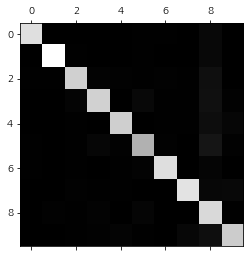

In [46]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

에러 비율 비교

In [47]:
row_sum=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sum

행이 실제 클래스 열이 예측한 클래스

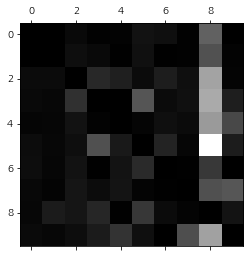

In [48]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

8이 밝은걸로 봐서 많은 숫자들이 8로 잘못 예측  
3,5이 혼동을 줌

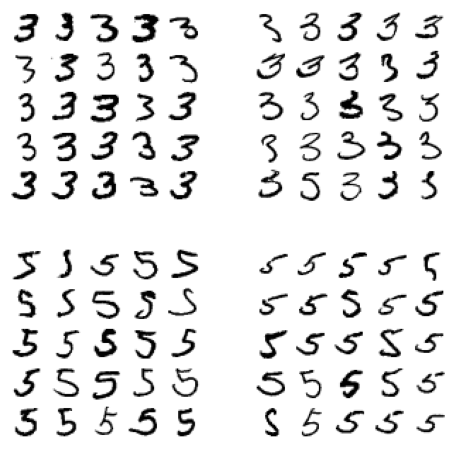

In [49]:
cl_a,cl_b=3,5
x_aa=x_train[(y_train==cl_a)&(y_train_pred==cl_a)]
x_bb=x_train[(y_train==cl_b)&(y_train_pred==cl_b)]
x_ba=x_train[(y_train==cl_b)&(y_train_pred==cl_a)]
x_ab=x_train[(y_train==cl_a)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(x_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(x_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(x_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(x_bb[:25],images_per_row=5)
plt.show()

분류기가 실수한 원인은 선형 모델인 SGD를 사용해서

# 다중 레이블 분류

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(x_train,y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [52]:
y_train_knn_pred=cross_val_predict(knn_clf,x_train,y_multilabel,cv=3)

In [53]:
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.976410265560605

가중치가 같다고 가정

# 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화

In [54]:
noise=np.random.randint(0,100,(len(x_train),784))
x_train_mod=x_train+noise

In [55]:
noise=np.random.randint(0,100,(len(x_test),784))
x_test_mod=x_test+noise

In [56]:
y_train_mod=x_train
y_test_mod=x_test

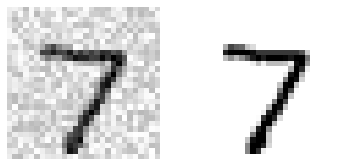

In [87]:
some_index = 0
plt.subplot(121); plot_digit(x_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

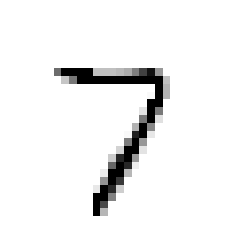

In [89]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)